In [1]:
import glob
import os
import re

import pandas as pd

def load_adv_csv() -> pd.DataFrame:
    # Load all the stuff
    adv_df = None
    for model_name in ['model_3_1', 'model_3_2', 'model_3_3', 'model_3_3__placeholder', 'model_3_4']:
        adv_csvs_folder = os.path.normpath(
            os.path.join(
                os.getcwd(), os.pardir, 'adv_csvs_full'
            )
        )
        print('adv_csvs_folder', adv_csvs_folder)
        csv_filenames = glob.glob(
            os.path.join(
                adv_csvs_folder,
                f'{model_name}/results__b_1__k_1__n_1000.csv'
            )
        )
        print(model_name, csv_filenames)
        for filename in csv_filenames:
            df = pd.read_csv(filename)
            df['model_name'] = re.search(r'adv_csvs_full/(model_\d.*)/.+.csv', filename).group(1)
            df['i'] = df.index

            df = df[df['result_type'] == 'Successful']

            mini_df = df[['original_text', 'perturbed_text', 'model_name', 'i']]
            
            if adv_df is None:
                adv_df = mini_df
            else:
                adv_df = pd.concat((adv_df, mini_df), axis=0)
    
    for text_key in ['perturbed_text', 'original_text']:
        # Put newlines back
        adv_df[text_key] = adv_df[text_key].apply(lambda s: s.replace('<SPLIT>', '\n'))

        # Standardize mask tokens
        adv_df[text_key] = adv_df[text_key].apply(lambda s: s.replace('[MASK]', '<mask>'))
    return adv_df

In [2]:
df = load_adv_csv()

adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full
model_3_1 ['/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full/model_3_1/results__b_1__k_1__n_1000.csv']
adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full
model_3_2 ['/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full/model_3_2/results__b_1__k_1__n_1000.csv']
adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full
model_3_3 []
adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full
model_3_3__placeholder ['/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full/model_3_3__placeholder/results__b_1__k_1__n_1000.csv']
adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full
model_3_4 ['/home/jxm3/research/deidentification/unsupervised-deidentif

In [3]:
df.groupby('model_name').count()

,original_text,perturbed_text,i
model_name,,,
model_3_1,993,993,993
model_3_2,991,991,991
model_3_3__placeholder,992,992,992
model_3_4,987,987,987


In [4]:
df.iloc[0]

original_text     leonard shenoff randle ( born february 12 , 19...
perturbed_text    leonard shenoff <mask> ( born february 12 , <m...
model_name                                                model_3_1
i                                                                 0
Name: 0, dtype: object

In [5]:
def get_masked_words(row):
    masked_words = []
    for original_word, perturbed_word in zip(row['original_text'].split(' '), row['perturbed_text'].split(' ')):
        if perturbed_word == '<mask>':
            masked_words.append(original_word)
    return masked_words


df['masked_words'] = df.apply(get_masked_words, axis=1)

In [6]:
print(df['masked_words'].explode().value_counts()[:30])

the          393
in           268
and          222
a            196
``           190
of           179
was          168
is           136
for          123
september    107
july         107
august       105
october      101
december     101
january       99
to            95
march         93
born          90
november      89
june          89
february      87
may           85
april         74
as            73
john          65
1991          64
his           63
1978          61
1989          60
at            54
Name: masked_words, dtype: int64


<AxesSubplot:>

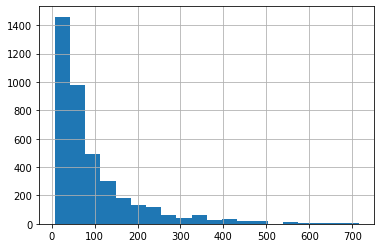

In [7]:
df['num_words'] = df['perturbed_text'].apply(lambda s: s.count(' ') + 1)
df['num_words'].hist(bins=20)

In [8]:
df.groupby('model_name').count()

,original_text,perturbed_text,i,masked_words,num_words
model_name,,,,,
model_3_1,993,993,993,993,993
model_3_2,991,991,991,991,991
model_3_3__placeholder,992,992,992,992,992
model_3_4,987,987,987,987,987


In [9]:
from typing import List, Tuple

from IPython.display import HTML, display
import html

wrap_th = lambda s: f'<th>{s}</th>'
wrap_td = lambda s: f'<td>{s}</td>'

def html_table_from_rows(rows: List[str]) -> str:
    table = '<table>'
    table += '<tr>'
    for header_key in rows[0]:
        table += wrap_th(header_key)
    table += '</tr>'
    for i in range(1,len(rows)):
        table += '<tr>'
        for row_value in rows[i]:
            table += wrap_td(row_value)
        table += '</tr>'
    table += '</table>'
    return table

def html_format_doc(doc: str) -> str:
    # return html.escape(doc)
    return doc.replace('<mask>', '<span style="color: darkgray; background-color: darkgray; line-height: 16px; font-size: 14px; font-weight: 100"> &lt;mask&gt;</span>')


rows = [['doc', 'redacted_doc']]
for _,ex in df[df['model_name'] == 'model_3_2'].iterrows(): 
    doc = ex['original_text']
    perturbed_doc = html_format_doc(ex['perturbed_text'])
    rows.append([doc, perturbed_doc])
    if len(rows)>20: break

# print(rows)
display(HTML(html_table_from_rows(rows)))

# display(HTML(html_table_from_rows([
#     [1,2], ['jack', 'alex']
# ])))

In [10]:

df_with_the_masked = df[df.apply(lambda row: 'the' in row['masked_words'], axis=1)]
df_with_the_masked.head()
rows = [['doc', 'redacted_doc']]
for _,ex in df_with_the_masked.sort_values(by='num_words').iterrows(): 
    doc = ex['original_text']
    perturbed_doc = html_format_doc(ex['perturbed_text'])
    rows.append([doc, perturbed_doc])
    if len(rows)>20: break

# print(rows)
display(HTML(html_table_from_rows(rows)))

# display(HTML(html_table_from_rows([
#     [1,2], ['jack', 'alex']
# ])))

doc,redacted_doc
"begziin yavuukhulan ( , 1929-1982 ) was a mongolian poet of the communist era that wrote in mongolian and russian .","<mask> <mask> ( , <mask> ) <mask> <mask> mongolian <mask> of <mask> communist <mask> <mask> <mask> in <mask> and <mask> ."
sarosh homi kapadia ( ) ( hindi : सरोश होमी कापडिया ) ( born 29 september 1947 ) was the thirty-eighth chief justice of india .,<mask> <mask> <mask> ( ) ( hindi : <mask>ो <mask> <mask>ोमी <mask>ा <mask>ि <mask>ा ) ( <mask> <mask> <mask> <mask> ) was <mask> <mask> <mask> <mask> <mask> <mask> .
nadezhda shitikova ( ; 15 september 1923 -- 1995 ) was a soviet fencer . she competed in the women 's individual foil event at the 1952 and 1956 summer olympics .,<mask> <mask> ( ; <mask> <mask> <mask> -- 1995 ) <mask> <mask> <mask> <mask> . <mask> <mask> <mask> <mask> <mask> ' <mask> <mask> foil <mask> <mask> <mask> <mask> <mask> 1956 <mask> <mask> .
cedric van der gun ( born 5 may 1979 in the hague ) is a dutch football winger who is currently without a club after being released by fc utrecht .,<mask> van <mask> <mask> ( born 5 <mask> <mask> in <mask> <mask> ) is a dutch football <mask> who is currently without a club after being released by fc <mask> .
cedric van der gun ( born 5 may 1979 in the hague ) is a dutch football winger who is currently without a club after being released by fc utrecht .,<mask> <mask> <mask> <mask> ( <mask> 5 may <mask> <mask> <mask> <mask> ) <mask> <mask> <mask> <mask> <mask> who is <mask> without a club after <mask> <mask> <mask> <mask> <mask> .
saša zorić ( serbian cyrillic : Саша Зорић ; born 2 september 1974 ) is a retired serbian international football player . he also played indoor soccer during his tenure in the united states .,<mask> <mask> ( serbian <mask> : <mask> <mask> ; <mask> <mask> september <mask> ) <mask> <mask> <mask> <mask> <mask> <mask> player . <mask> <mask> played <mask> <mask> <mask> <mask> <mask> <mask> <mask> united states .
somabhai gandalal koli patel ( born 10 august 1940 ) is a member of the 15th lok sabha of india . he represents the surendranagar constituency of gujarat and is a member of the indian national congress .,<mask> <mask> <mask> <mask> ( <mask> <mask> <mask> <mask> ) <mask> a member <mask> <mask> 15th lok sabha of india . he <mask> <mask> <mask> <mask> of gujarat <mask> <mask> <mask> member <mask> <mask> indian national congress .
"georgiy daneliya ( `` giorgi danelia '' ; ; born 25 august 1930 ) is a soviet/georgian/russian film director , who became known throughout the soviet union for his `` sad comedies '' ( as he styles them ) .","<mask> <mask> ( <mask> <mask> danelia '' ; ; <mask> <mask> august <mask> ) <mask> <mask> soviet/ <mask>/ <mask> <mask> <mask> , <mask> <mask> known <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> comedies '' ( as <mask> <mask> <mask> ) ."
"piotr sczypa , now known as peter sczypa ( born 19 april 1948 ) is a former pair skater who competed for poland with janina poremska and teresa skrzek . he is currently the national ladies ' figure skating coach of germany .","<mask> <mask> , <mask> known <mask> <mask> <mask> ( <mask> <mask> april 1948 ) <mask> a former <mask> skater <mask> <mask> <mask> <mask> <mask> <mask> poremska <mask> teresa skrzek . <mask> is currently <mask> national ladies ' <mask> <mask> coach <mask> germany ."
"trung jered canidate ( born march 3 , 1977 ) is a former american football running back in the nfl . drafted out of arizona , canidate was selected with the 31st overall pick of the 2000 nfl draft by the st. louis rams .","<mask> <mask> <mask> ( born march 3 , <mask> ) is <mask> former <mask> <mask> <mask> <mask> in <mask> <mask> . <mask> <mask> <mask> <mask> , canidate <mask> selected with the 31st overall pick of <mask> <mask> <mask> draft by the st. louis <mask> ."


In [11]:

df_with_a_an_masked = df[df.apply(lambda row: ('a' in row['masked_words'] or 'an' in row['masked_words']), axis=1)]
df_with_a_an_masked.head()
rows = [['doc', 'redacted_doc']]
for _,ex in df_with_a_an_masked.sort_values(by='num_words').iterrows(): 
    doc = ex['original_text']
    perturbed_doc = html_format_doc(ex['perturbed_text'])
    rows.append([doc, perturbed_doc])
    if len(rows)>20: break

# print(rows)
display(HTML(html_table_from_rows(rows)))


doc,redacted_doc
Étienne jalenques ( born 10 december 1934 ) is a french modern pentathlete . he competed at the 1960 summer olympics .,<mask> <mask> ( born 10 <mask> <mask> ) is <mask> <mask> modern pentathlete . he competed at the <mask> summer olympics .
"begziin yavuukhulan ( , 1929-1982 ) was a mongolian poet of the communist era that wrote in mongolian and russian .","<mask> <mask> ( , <mask> ) <mask> <mask> mongolian <mask> of <mask> communist <mask> <mask> <mask> in <mask> and <mask> ."
"j. g. blackman was a west indian cricket umpire . he stood in one test match , west indies vs. england , in 1935 .","<mask>. <mask>. <mask> <mask> <mask> <mask> indian <mask> <mask> . he <mask> in one test <mask> , <mask> <mask> vs. england , in <mask> ."
annia rivera ( born 13 august 1991 ) is a cuban diver . she competed in the 10 metre platform event at the 2012 summer olympics .,<mask> <mask> ( born 13 august <mask> ) is <mask> <mask> diver . she competed in the 10 metre platform event at the 2012 summer olympics .
manuel rolando iturra urrutia ( born 23 june 1984 ) is a chilean professional footballer who plays for italian club udinese calcio as a defensive midfielder .,<mask> rolando <mask> <mask> ( born 23 <mask> <mask> ) is <mask> <mask> professional footballer who plays for italian club udinese calcio as a <mask> midfielder .
"manoel lourenço da silva filho , known as simply manoel ( born 2 february 1978 ) , is a brazilian retired footballer who played as a centre forward .","manoel <mask> <mask> <mask> <mask> , known as simply manoel ( born 2 february <mask> ) , is a brazilian retired footballer who played as <mask> <mask> <mask> ."
nguyễn hoàng minh is a vietnamese football referee who has been a full international referee for fifa . he also refereed at the regional league such as 2011 sea games .,<mask> <mask> <mask> <mask> <mask> <mask> football referee who has been a full international referee for <mask> . he also refereed at the <mask> league such as 2011 sea games .
"aristotelis karasalidis ( greek : Αριστοτέλης Καρασαλίδης ; born 3 may 1991 in thessaloniki , greece ) is a greek footballer currently playing for iraklis , as a defender .","<mask> <mask> ( greek : <mask> <mask> ; <mask> <mask> <mask> <mask> <mask> <mask> , greece ) <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> , <mask> <mask> <mask> ."
cedric van der gun ( born 5 may 1979 in the hague ) is a dutch football winger who is currently without a club after being released by fc utrecht .,<mask> <mask> <mask> <mask> ( <mask> 5 may <mask> <mask> <mask> <mask> ) <mask> <mask> <mask> <mask> <mask> who is <mask> without a club after <mask> <mask> <mask> <mask> <mask> .
nadezhda shitikova ( ; 15 september 1923 -- 1995 ) was a soviet fencer . she competed in the women 's individual foil event at the 1952 and 1956 summer olympics .,<mask> <mask> ( ; <mask> <mask> <mask> -- 1995 ) <mask> <mask> <mask> <mask> . <mask> <mask> <mask> <mask> <mask> ' <mask> <mask> foil <mask> <mask> <mask> <mask> <mask> 1956 <mask> <mask> .


In [12]:

df_with_to_for_masked = df[df.apply(lambda row: ('to' in row['masked_words'] or 'for' in row['masked_words']), axis=1)]
df_with_to_for_masked.head()
rows = [['doc', 'redacted_doc']]
for _,ex in df_with_to_for_masked.iterrows(): 
    doc = ex['original_text']
    perturbed_doc = html_format_doc(ex['perturbed_text'])
    rows.append([doc, perturbed_doc])
    if len(rows)>20: break

# print(rows)
display(HTML(html_table_from_rows(rows)))


In [13]:
df.apply(lambda row: 'was' in row['masked_words'], axis=1).sum() / len(df)

0.03204642947262175

In [14]:
df.apply(lambda row: 'is' in row['masked_words'], axis=1).sum() / len(df)

0.028766086298258896

In [15]:
df['original_text'].map(lambda s: s.count(' was ')).sum()

5547

In [16]:
df['original_text'].map(lambda s: s.count(' is ')).sum()

4080

In [17]:
df['original_text'].map(lambda s: s.count('was')).sum()

5663

In [18]:
he_his_her_hers = df[df.apply(
        lambda ex: (
            ('he' in ex['masked_words']) or ('she' in ex['masked_words']) or ('his' in ex['masked_words']) or ('her' in ex['masked_words']) or ('him' in ex['masked_words']) or ('hers' in ex['masked_words'])
        ), axis=1)]
he_his_her_hers

,original_text,perturbed_text,model_name,i,masked_words,num_words
77,"taylor milne ( born september 14 , 1981 in cal...","<mask> <mask> ( born september 14 , <mask> in ...",model_3_1,77,"[taylor, milne, 1981, ontario, canadian, made,...",358
497,charlotte harrison ( born 31 july 1989 ) is a ...,<mask> <mask> ( <mask> 31 july <mask> ) is a n...,model_3_1,497,"[charlotte, harrison, born, 1989, has, for, wo...",331
514,"tracey eide ( born july 31 , 1954 ) is a democ...","<mask> eide ( born july 31 , <mask> ) is a <ma...",model_3_1,514,"[tracey, 1954, democratic, washington, senate,...",128
693,"daniel j. `` dan '' vella ( born november 18 ,...",<mask> <mask>. `` dan '' <mask> ( born novembe...,model_3_1,693,"[daniel, vella, 1955, toronto, ontario, canadi...",112
712,johnny duhan ( born 1 january 1950 ) started h...,<mask> duhan ( <mask> <mask> january <mask> ) ...,model_3_1,712,"[johnny, born, 1, 1950, his, career, group, ba...",242
...,...,...,...,...,...,...
28,jacoba surie ( 5 september 1879 -- 5 february ...,<mask> <mask> ( 5 <mask> <mask> -- 5 february ...,model_3_4,28,"[jacoba, surie, september, 1879, 1970, amsterd...",71
306,dharmaditya dharmacharya ( devanagari : धर्माद...,<mask> <mask> ( devanagari : <mask>्<mask>ा<ma...,model_3_4,306,"[dharmaditya, dharmacharya, born, man, vaidya,...",117
344,"marie catherine laveau ( september 10 , 1794 -...","<mask> <mask> <mask> ( september 10 , <mask> -...",model_3_4,344,"[marie, catherine, laveau, 1794, creole, voodo...",125
854,saša zorić ( serbian cyrillic : Саша Зорић ; b...,<mask> zorić ( serbian cyrillic : <mask> Зорић...,model_3_4,854,"[saša, Саша, 2, september, 1974, retired, inte...",34


In [19]:
rows = [['doc', 'redacted_doc']]
for _,ex in he_his_her_hers.iterrows(): 
    doc = ex['original_text']
    perturbed_doc = html_format_doc(ex['perturbed_text'])
    rows.append([doc, perturbed_doc])
    if len(rows)>20: break

# print(rows)
display(HTML(html_table_from_rows(rows)))
